<div style="border:1px solid #ddd; background:#f9f9f9; padding:16px; border-radius:8px; margin:20px 0;">
  <div style="float:right; font-size:0.9em; color:#666;">By: Vince Mbanze | Date: July 13, 2025</div>
  <h1 style="text-align:center; color:#2c3e50;">🔬 BindingDB Analysis: Predicting BTK Inhibitor Potency 🔬</h1>
</div>

<div style="border-left:4px solid #34495e; background:#eaedf0; padding:12px; border-radius:6px; margin:20px 0;">
  <h3>🗂️ Overview</h3>
  <p>
    <strong>Part 1:</strong> Data Preparation &amp; Featurization  
    |  
    <strong>Part 2:</strong> Machine Learning &amp; Interpretation
  </p>
</div>

<div style="border-left:4px solid #3498db; background:#eef6fc; padding:12px; border-radius:6px; margin:20px 0;">
  <h3>📖 Workflow Summary</h3>
  <p>
    This notebook details a complete machine learning workflow for predicting the bioactivity of chemical compounds against Bruton's tyrosine kinase (BTK), a key target in drug discovery. The process begins with raw data from the BindingDB database and ends with a predictive model and interpretation of its most important features.
  </p>
</div>

<div style="border-left:4px solid #2ecc71; background:#ecf9f1; padding:12px; border-radius:6px; margin:20px 0;">
  <h3>🔑 Key Stages</h3>
  <ul>
    <li><strong>Data Ingestion &amp; Cleaning:</strong> Load and filter high‑quality BTK data with Spark.</li>
    <li><strong>Feature Engineering:</strong> Generate physicochemical descriptors and molecular fingerprints.</li>
    <li><strong>Model Training &amp; Evaluation:</strong> Train a Random Forest Regressor to predict pIC₅₀.</li>
    <li><strong>Hyperparameter Tuning:</strong> Optimize model settings for peak performance.</li>
    <li><strong>Feature Importance &amp; Prediction:</strong> Identify top predictors and score compounds.</li>
  </ul>
</div>


<div style="border-left:4px solid #e67e22; background:#fef6ec; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>1️⃣ Initial Setup &amp; Data Exploration</h3>
  <p>
    We begin by spinning up a SparkSession—ideal for processing the massive BindingDB TSV (millions of rows) that would choke pandas. After loading the file, we inspect its schema to see all available bioactivity columns.
  </p>
  <h4>🔎 Checking for Missing Values</h4>
  <p>
    We tally nulls in the key assay measurements (Ki, IC50, Kd, EC50) and find that <strong>IC50</strong> is by far the most reported value—making it our best prediction target.
  </p>
  <h4>📑 Filtering the Dataset</h4>
  <ul>
    <li>Only <strong>Human</strong> (Homo sapiens) targets are retained.</li>
    <li>Entries must have a non‑null <strong>IC50</strong> value.</li>
  </ul>
  <p>
    From this cleaned subset, we rank targets by IC50 count.  Tyrosine‑protein kinase BTK (<code>Q06187</code>) tops the list with <em>~16 000</em> measurements—ideal for training a robust model.
  </p>
</div>


In [67]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BindingDB") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

df = spark.read.csv(
    r"C:\Users\vince\Coursework\Chemistry\BindingDB_All.tsv",
    sep="\t",
    header=True,
    inferSchema=True
)

df.show(5)
df.printSchema()


+-------------------------+--------------------+--------------------+--------------------+-------------------+---------------------+--------------------+---------------------------------------------------------+-------+---------+-------+---------+-------------+----------+---+--------+--------------------+-----------------+-------------------+-------+-----------+-------------+--------------------+-------------------+-----------------+--------------------+---------------------------+---------------------------+---------------------------------------+--------------------+-----------------------------------+-----------+-----------+------------------+-------------------+---------------------+------------------------+-----------------+-----------------+--------------------------------------------------------------------+---------------------------------+---------------------------+------------------------------------------------------+------------------------------------------------+--------

In [68]:
from pyspark.sql.functions import col, when, count

# the actual columns you care about
key_cols = [
    "Ki (nM)",
    "IC50 (nM)",
    "Kd (nM)",
    "Target Source Organism According to Curator or DataSource",
    "pH",
    "Temp (C)",
    "Curation/DataSource"
]

# build a small null‐count DataFrame
nulls_small = df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in key_cols
])

print("=== NULL counts for key columns ===")
nulls_small.show(truncate=False)


=== NULL counts for key columns ===
+-------+---------+-------+---------------------------------------------------------+-------+--------+-------------------+
|Ki (nM)|IC50 (nM)|Kd (nM)|Target Source Organism According to Curator or DataSource|pH     |Temp (C)|Curation/DataSource|
+-------+---------+-------+---------------------------------------------------------+-------+--------+-------------------+
|2433764|996436   |2924207|1024245                                                  |2825769|2840126 |0                  |
+-------+---------+-------+---------------------------------------------------------+-------+--------+-------------------+



In [69]:
from pyspark.sql.functions import col, count
from pyspark.sql.types import DoubleType

# 1. Cast IC50 to double
df2 = df.withColumn("IC50_nM_double", col("IC50 (nM)").cast(DoubleType()))

# 2. Filter to IC50 + human-organism
df_ic50_human = (
    df2
    .filter(col("IC50_nM_double").isNotNull())
    .filter(col("Target Source Organism According to Curator or DataSource")
            .rlike("Human|Homo sapiens"))
)

# 3. Row count
print("Rows with IC50 & human target:", df_ic50_human.count())

# 4. IC50 quantiles (nM)
quantiles = df_ic50_human.approxQuantile("IC50_nM_double",
                                        [0.01, 0.1, 0.5, 0.9, 0.99],
                                        0.0)
print("IC50 quantiles (nM) → 1%,10%,50%,90%,99%:", quantiles)

# 5. Top 10 proteins by IC50 measurement count
df_ic50_human.groupBy("UniProt (SwissProt) Primary ID of Target Chain 1") \
    .agg(count("*").alias("ic50_count")) \
    .orderBy(col("ic50_count").desc()) \
    .limit(10) \
    .show(truncate=False)


Rows with IC50 & human target: 890173
IC50 quantiles (nM) → 1%,10%,50%,90%,99%: [0.18, 3.0, 160.0, 12300.0, 270600.0]
+------------------------------------------------+----------+
|UniProt (SwissProt) Primary ID of Target Chain 1|ic50_count|
+------------------------------------------------+----------+
|Q06187                                          |16141     |
|P00533                                          |16038     |
|O60674                                          |14169     |
|P56817                                          |12172     |
|Q13547                                          |11550     |
|Q12809                                          |11207     |
|P23458                                          |10652     |
|P35968                                          |10584     |
|Q9NWZ3                                          |10054     |
|NULL                                            |9882      |
+------------------------------------------------+----------+



<div style="border-left:4px solid #9b59b6; background:#f6eefc; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>2️⃣ Data Preparation for Modeling</h3>
  
  <h4>📈 Calculating pIC₅₀</h4>
  <p>
    IC₅₀ values (in nanomolar) are transformed to the pIC₅₀ scale (<code>−log₁₀(IC₅₀ × 10⁻⁹)</code>) to normalize the range and highlight potency.  A higher pIC₅₀ means a more potent inhibitor.
  </p>
  
  <h4>🚫 Removing Outliers</h4>
  <p>
    A histogram shows most pIC₅₀ values cluster sensibly, but extreme values can skew the model.  We trim to <code>4.0 ≤ pIC₅₀ ≤ 11.0</code>, yielding <em>16 123</em> compounds.
  </p>
  
  <h4>🛠️ Feature Engineering</h4>
  <p>
    We convert SMILES into numerical descriptors via RDKit:
  </p>
  <ul>
    <li><strong>Physicochemical Descriptors:</strong> MolWt, LogP, TPSA, HBD, HBA.</li>
    <li><strong>Morgan Fingerprints:</strong> 2 048‑bit binary vectors capturing structural motifs.</li>
  </ul>
  
  <h4>✅ Final Cleaning &amp; Filtering</h4>
  <p>
    Molecules that RDKit failed to parse are dropped.  We then apply Lipinski’s Rule of Five to keep only drug‑like compounds, resulting in a clean set of <em>7 225</em> molecules ready for modeling.
  </p>
</div>


In [71]:
from pyspark.sql.functions import col, log10
from pyspark.sql.types import DoubleType

# 1. Ensure IC50 is a double (reuse the df2 you already made)
df2 = df.withColumn("IC50_nM_double", col("IC50 (nM)").cast(DoubleType()))

# 2. Filter to human + IC50 + target Q06187
df_q06187 = (
    df2
    .filter(col("IC50_nM_double").isNotNull())
    .filter(col("Target Source Organism According to Curator or DataSource")
            .rlike("Human|Homo sapiens"))
    .filter(col("UniProt (SwissProt) Primary ID of Target Chain 1") == "Q06187")
)

print("Records for Q06187:", df_q06187.count())

# 3. Create pIC50 = −log10(IC50 [M]) = 9 − log10(IC50 [nM])
df_q06187 = df_q06187.withColumn(
    "pIC50",
    (-log10(col("IC50_nM_double")) + 9.0)
)

# 4. Quick summary of pIC50
df_q06187.select("pIC50").describe().show()

pdf = df_q06187.toPandas()
pdf.to_csv("q06187_ic50.csv", index=False)


Records for Q06187: 16141
+-------+------------------+
|summary|             pIC50|
+-------+------------------+
|  count|             16140|
|   mean| 7.723697021406317|
| stddev|1.2091979059486981|
|    min|2.6020599913279625|
|    max|12.585026652029182|
+-------+------------------+



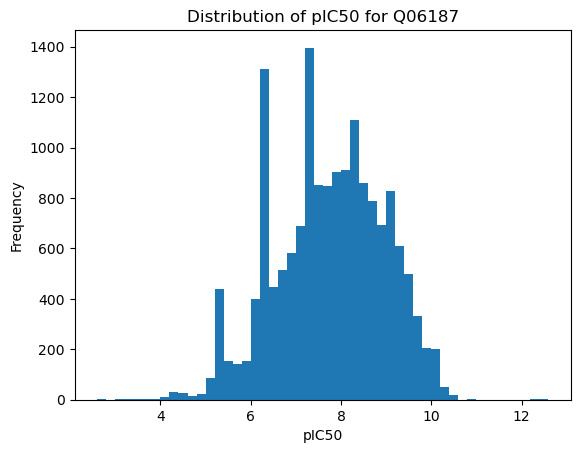

In [72]:
import matplotlib.pyplot as plt

pdf = df_q06187.toPandas()
plt.hist(pdf['pIC50'], bins=50)
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.title('Distribution of pIC50 for Q06187')
plt.show()


In [73]:
from pyspark.sql.functions import col

df_trimmed = df_q06187.filter((col("pIC50") >= 4.0) & (col("pIC50") <= 11.0))
print("Rows after trimming:", df_trimmed.count())


Rows after trimming: 16123


In [74]:
# 1. Schema
print("=== Schema of df_trimmed ===")
df_trimmed.printSchema()

# 2. Sample rows
print("=== First 10 rows of df_trimmed ===")
df_trimmed.show(10, truncate=False)

# 3. Summary statistics on pIC50
print("=== Summary of pIC50 in df_trimmed ===")
df_trimmed.select("pIC50").describe().show()

# 4. Ligand & pIC50 preview
print("=== Ligand SMILES ↔ pIC50 (first 10) ===")
df_trimmed.select("Ligand SMILES", "pIC50") \
          .show(10, truncate=False)

# 5. How many unique compounds?
from pyspark.sql.functions import countDistinct
num_ligands = df_trimmed.select(countDistinct("Ligand SMILES")).collect()[0][0]
print(f"Unique ligands in df_trimmed: {num_ligands}")


=== Schema of df_trimmed ===
root
 |-- BindingDB Reactant_set_id: integer (nullable = true)
 |-- Ligand SMILES: string (nullable = true)
 |-- Ligand InChI: string (nullable = true)
 |-- Ligand InChI Key: string (nullable = true)
 |-- BindingDB MonomerID: integer (nullable = true)
 |-- BindingDB Ligand Name: string (nullable = true)
 |-- Target Name: string (nullable = true)
 |-- Target Source Organism According to Curator or DataSource: string (nullable = true)
 |-- Ki (nM): string (nullable = true)
 |-- IC50 (nM): string (nullable = true)
 |-- Kd (nM): string (nullable = true)
 |-- EC50 (nM): string (nullable = true)
 |-- kon (M-1-s-1): string (nullable = true)
 |-- koff (s-1): string (nullable = true)
 |-- pH: double (nullable = true)
 |-- Temp (C): string (nullable = true)
 |-- Curation/DataSource: string (nullable = true)
 |-- Article DOI: string (nullable = true)
 |-- BindingDB Entry DOI: string (nullable = true)
 |-- PMID: integer (nullable = true)
 |-- PubChem AID: string (nulla

In [75]:
df_trimmed.select("Ligand SMILES", "IC50_nM_double", "pIC50") \
          .show(10, truncate=False)


+---------------------------------------------------------------------------------+--------------+------------------+
|Ligand SMILES                                                                    |IC50_nM_double|pIC50             |
+---------------------------------------------------------------------------------+--------------+------------------+
|COc1ccc(N(C(=O)Oc2c(C)cccc2C)c2ccnc(Nc3cc(OC)c(OCCCN4CCN(C)CC4)c(OC)c3)n2)c(OC)c1|100.0         |7.0               |
|Cc1c(NC(=O)c2ccc(cc2)C(C)(C)C)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2CCOCC2)n1    |1.9           |8.721246399047171 |
|Cc1c(N)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2CCOCC2)n1                           |5441.0        |5.264321274094096 |
|CC(=O)Nc1cccc(c1C)-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2CCOCC2)n1                     |2687.0        |5.5707323335668315|
|Cc1c(NCc2ccc(cc2)C(C)(C)C)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2CCOCC2)n1        |9058.0        |5.042967683653062 |
|Cc1c(NC(=O)c2cccc(c2)C(C)(C)C)cccc1-c1cn(C)c(=O)c(Nc2cc

In [76]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors

# 1. Pull the three columns into pandas
pdf = df_trimmed \
    .select("Ligand SMILES", "IC50_nM_double", "pIC50") \
    .toPandas()

# 2. Set up your descriptor functions
DESC_FUNCS = [
    ("MolWt", Descriptors.MolWt),
    ("LogP",  Descriptors.MolLogP),
    ("TPSA",  Descriptors.TPSA),
    ("HBD",   Descriptors.NumHDonors),
    ("HBA",   Descriptors.NumHAcceptors),
]

def featurize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # fallback to NaNs and zeros if RDKit can’t parse
    if mol is None:
        descs = [np.nan] * len(DESC_FUNCS)
        fp    = np.zeros(2048, dtype=int)
    else:
        # physchem descriptors
        descs = [func(mol) for _, func in DESC_FUNCS]
        # Morgan fingerprint
        bv    = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr   = np.zeros(2048, dtype=int)
        for bit in bv.GetOnBits():
            arr[bit] = 1
        fp    = arr
    return descs, fp

# 3. Apply featurization
desc_list, fp_list = zip(*pdf["Ligand SMILES"].map(featurize))

# 4. Build DataFrames out of them
desc_df = pd.DataFrame(desc_list, columns=[name for name,_ in DESC_FUNCS])
fp_df   = pd.DataFrame(fp_list,   columns=[f"FP_{i}" for i in range(2048)])

# 5. Concatenate everything
features = pd.concat([pdf, desc_df, fp_df], axis=1)

# Inspect the first few rows
print(features.head())


[20:20:01] Explicit valence for atom # 3 N, 4, is greater than permitted
[20:20:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[20:20:04] Explicit valence for atom # 34 N, 4, is greater than permitted
[20:20:05] Explicit valence for atom # 29 N, 4, is greater than permitted


                                       Ligand SMILES  IC50_nM_double  \
0  COc1ccc(N(C(=O)Oc2c(C)cccc2C)c2ccnc(Nc3cc(OC)c...           100.0   
1  Cc1c(NC(=O)c2ccc(cc2)C(C)(C)C)cccc1-c1cn(C)c(=...             1.9   
2  Cc1c(N)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2C...          5441.0   
3  CC(=O)Nc1cccc(c1C)-c1cn(C)c(=O)c(Nc2ccc(cc2)C(...          2687.0   
4  Cc1c(NCc2ccc(cc2)C(C)(C)C)cccc1-c1cn(C)c(=O)c(...          9058.0   

      pIC50    MolWt     LogP    TPSA  HBD   HBA  FP_0  FP_1  ...  FP_2038  \
0  7.000000  686.810  6.22484  119.98  1.0  12.0     0     0  ...        0   
1  8.721246  579.701  5.52152  105.56  2.0   7.0     0     0  ...        0   
2  5.264321  419.485  2.55392  102.48  2.0   7.0     0     0  ...        0   
3  5.570732  461.522  2.93012  105.56  2.0   7.0     0     0  ...        0   
4  5.042968  565.718  5.88132   88.49  2.0   7.0     0     0  ...        0   

   FP_2039  FP_2040  FP_2041  FP_2042  FP_2043  FP_2044  FP_2045  FP_2046  \
0        0        0  

       feature  n_missing  pct_missing
IC50_nM_double          0     0.000000
         pIC50          0     0.000000
         MolWt          4     0.024809
          LogP          4     0.024809
          TPSA          4     0.024809
           HBD          4     0.024809
           HBA          4     0.024809
                  count        mean          std       min         25%  \
IC50_nM_double  16123.0  571.962497  3432.307239    0.0140    2.200000   
pIC50           16123.0    7.726060     1.201029    4.0000    6.886057   
MolWt           16119.0  496.989774    85.331036  188.1900  440.507000   
LogP            16119.0    4.266105     1.217433   -1.0891    3.463600   
TPSA            16119.0  109.469525    22.456630   44.0000   94.210000   
HBD             16119.0    2.265835     0.894548    0.0000    2.000000   
HBA             16119.0    6.573175     2.210919    2.0000    6.000000   

                       50%         75%            max  
IC50_nM_double   17.000000  130.000000 

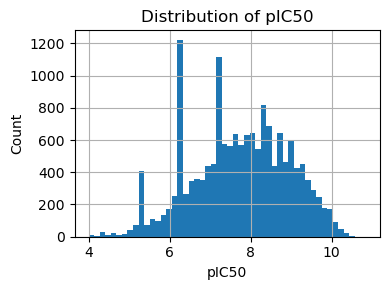

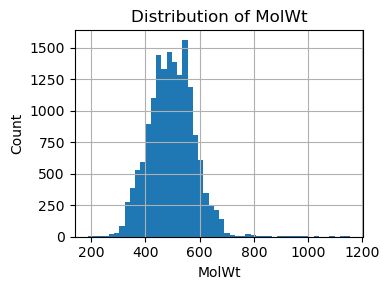

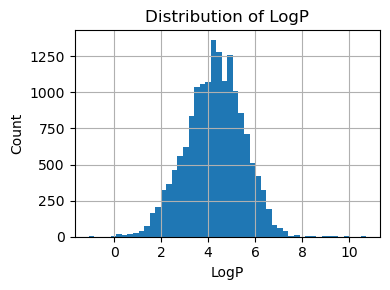

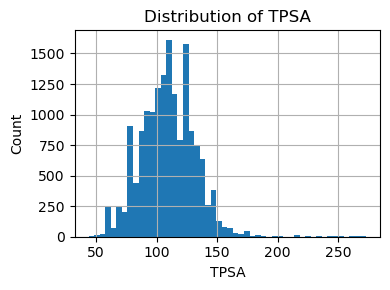

In [77]:
# 1. Missing‐value summary
cols = ["IC50_nM_double", "pIC50", "MolWt", "LogP", "TPSA", "HBD", "HBA"]
missing = pd.DataFrame({
    "feature":     cols,
    "n_missing":   [features[c].isna().sum()    for c in cols],
    "pct_missing": [features[c].isna().mean()*100 for c in cols]
})
# Print without markdown:
print(missing.to_string(index=False))

# 2. Descriptive statistics
desc = features[cols].describe().T
print(desc)

# 3. Histograms
import matplotlib.pyplot as plt
for feature in ["pIC50", "MolWt", "LogP", "TPSA"]:
    plt.figure(figsize=(4,3))
    features[feature].hist(bins=50)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [78]:
features = features.dropna(subset=["MolWt"])


In [79]:
features = features[
  (features.MolWt <= 500) &
  (features.LogP <= 5) &
  (features.HBD  <= 5) &
  (features.HBA  <= 10) &
  (features.TPSA <= 140)
]


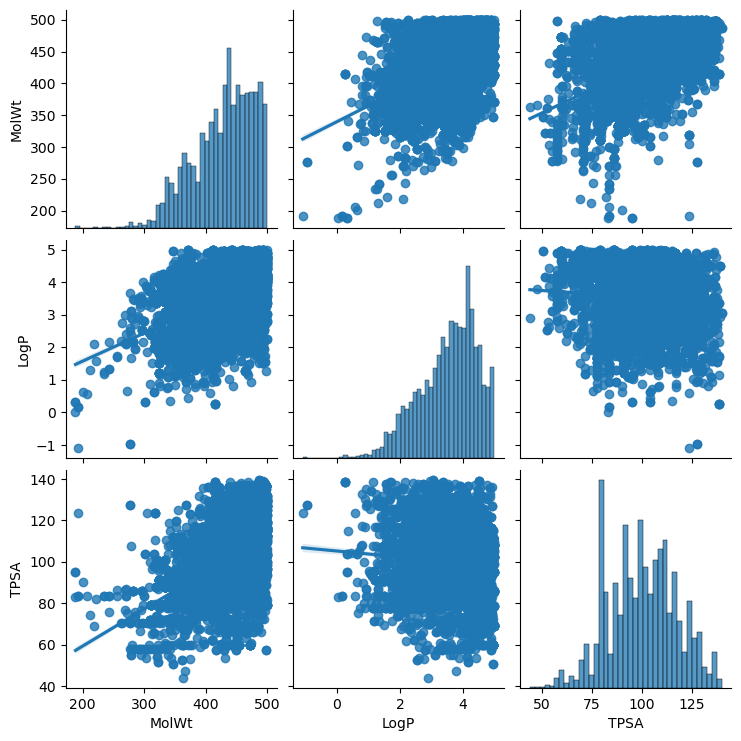

In [80]:
import seaborn as sns
sns.pairplot(features, vars=["MolWt","LogP","TPSA"], y_vars="pIC50", kind="reg");


In [82]:
print(features.shape)

(7225, 2056)


In [83]:
features.head()

,Ligand SMILES,IC50_nM_double,pIC50,MolWt,LogP,TPSA,HBD,HBA,FP_0,FP_1,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
2,Cc1c(N)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2C...,5441.00,5.264321,419.485,2.55392,102.48,2.0,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CC(=O)Nc1cccc(c1C)-c1cn(C)c(=O)c(Nc2ccc(cc2)C(...,2687.00,5.570732,461.522,2.93012,105.56,2.0,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)C1CCCN(C...,0.72,9.142668,440.507,4.21730,99.16,1.0,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,C\C=C\C(=O)N1CCCC(C1)n1nc(-c2ccc(Oc3ccccc3)cc2...,20.00,7.698970,454.534,4.60740,99.16,1.0,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)C1CCCN(C...,0.52,9.283997,476.562,3.97800,116.23,1.0,8.0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div style="border-left:4px solid #e74c3c; background:#fdecec; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>3️⃣ Model Training &amp; Evaluation</h3>
  
  <h4>🔀 Data Splitting</h4>
  <p>
    We partition the cleaned dataset into <strong>80% training</strong>, <strong>10% validation</strong>, and <strong>10% testing</strong> subsets.  This separation ensures unbiased performance estimates on completely unseen data.
  </p>
  
  <h4>🏋️ Model Training</h4>
  <p>
    A <strong>Random Forest Regressor</strong> is fit on the training set.  By aggregating many decision trees, the ensemble approach delivers robustness and strong predictive power.
  </p>
  
  <h4>📊 Initial Evaluation</h4>
  <p>
    On the held‑out test set, the model achieves:
  </p>
  <ul>
    <li><strong>RMSE:</strong> 0.680</li>
    <li><strong>R²:</strong> 0.716 (≈ 72% of variance explained)</li>
  </ul>
  <p>
    These metrics reflect a high‑quality fit for pIC₅₀ prediction.  

In [85]:
import pandas as pd

# Load into a pandas DataFrame
features = pd.read_csv('features.csv')
print("Pandas DataFrame shape:", features.shape)
print(features.head())

Pandas DataFrame shape: (7225, 2056)
                                       Ligand SMILES  IC50_nM_double  \
0  Cc1c(N)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2C...         5441.00   
1  CC(=O)Nc1cccc(c1C)-c1cn(C)c(=O)c(Nc2ccc(cc2)C(...         2687.00   
2  Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)C1CCCN(C...            0.72   
3  C\C=C\C(=O)N1CCCC(C1)n1nc(-c2ccc(Oc3ccccc3)cc2...           20.00   
4  Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)C1CCCN(C...            0.52   

      pIC50    MolWt     LogP    TPSA  HBD  HBA  FP_0  FP_1  ...  FP_2038  \
0  5.264321  419.485  2.55392  102.48  2.0  7.0     0     0  ...        0   
1  5.570732  461.522  2.93012  105.56  2.0  7.0     0     0  ...        0   
2  9.142668  440.507  4.21730   99.16  1.0  7.0     0     0  ...        0   
3  7.698970  454.534  4.60740   99.16  1.0  7.0     0     0  ...        0   
4  9.283997  476.562  3.97800  116.23  1.0  8.0     0     0  ...        0   

   FP_2039  FP_2040  FP_2041  FP_2042  FP_2043  FP_2044  FP_2045  F

In [86]:
feat_cols = [f"FP_{i}" for i in range(2048)] + ["MolWt","LogP","TPSA","HBD","HBA"]


In [87]:
from sklearn.model_selection import train_test_split

X = features[feat_cols]
y = features["pIC50"]

# 80/10/10 split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)
# e.g. (5780, 2053) (722, 2053) (723, 2053)


(5780, 2053) (722, 2053) (723, 2053)


In [96]:
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_squared_error, r2_score
import numpy as np

# 1) split (as you already have):
#    X_train, X_val, X_test, y_train, y_val, y_test

# 2) fit
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 3) predict
preds = model.predict(X_test)

# 4) compute RMSE & R²
mse  = mean_squared_error(y_test, preds)       # this returns MSE
rmse = np.sqrt(mse)                            # take sqrt for RMSE
r2   = r2_score(y_test, preds)

print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


RMSE: 0.680
R²:   0.716


In [98]:
import pandas as pd

# 1) pull out the raw importances
importances = model.feature_importances_

# 2) recreate your feature‐name list in the same order you passed into .fit()
feat_cols = [f"FP_{i}" for i in range(2048)] + ["MolWt", "LogP", "TPSA", "HBD", "HBA"]

# 3) wrap into a pandas Series so we can index by name
imp_ser = pd.Series(importances, index=feat_cols)

# 4) see the phys‐chem descriptor importances
print(imp_ser[["MolWt","LogP","TPSA","HBD","HBA"]].sort_values(ascending=False))

# 5) and maybe the top 10 fingerprint bits
print("\nTop 10 fingerprint bits:")
print(imp_ser.filter(like="FP_").sort_values(ascending=False).head(10))


MolWt    0.038967
TPSA     0.032936
LogP     0.029210
HBA      0.010363
HBD      0.003289
dtype: float64

Top 10 fingerprint bits:
FP_339     0.196014
FP_1377    0.076575
FP_694     0.031347
FP_1645    0.023560
FP_949     0.018820
FP_407     0.016451
FP_889     0.015772
FP_703     0.013192
FP_149     0.009961
FP_784     0.009332
dtype: float64


--- Visualizing Substructures for Top 8 Fingerprint Bits ---


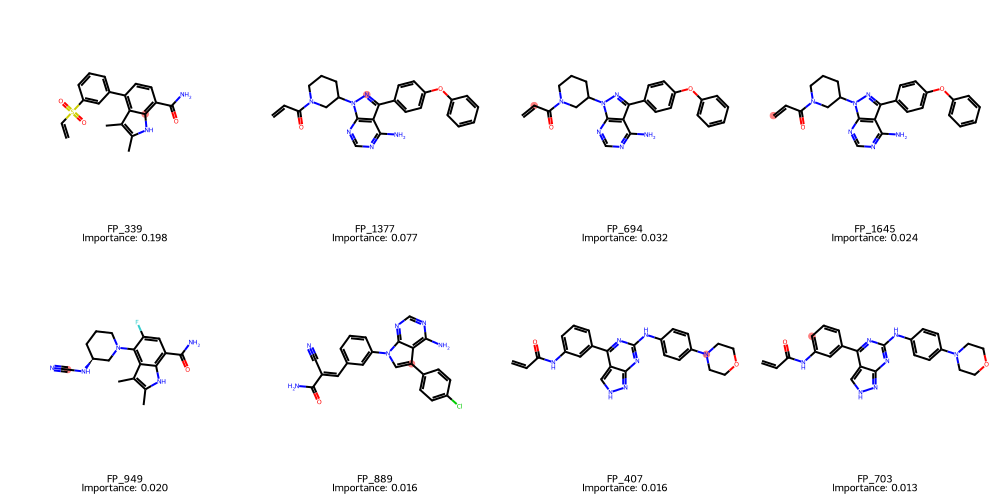

In [110]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from IPython.display import Image
import pandas as pd

# 1. Get feature importances from the trained model (assuming 'best_model' and 'feat_cols' are in memory)
importances = best_model.feature_importances_
imp_series = pd.Series(importances, index=feat_cols)

# 2. Identify the top N most important fingerprint bits
top_n = 8
fp_importances = imp_series.filter(like="FP_")
top_fp_series = fp_importances.sort_values(ascending=False).head(top_n)

print(f"--- Visualizing Substructures for Top {top_n} Fingerprint Bits ---")

# 3. Prepare lists for the grid image function
mols_to_draw = []
legends = []
highlight_info = []

for fp_name, importance in top_fp_series.items():
    bit_id = int(fp_name.split('_')[1])
    
    # Find an example molecule that contains this bit
    smiles = features[features[fp_name] == 1]["Ligand SMILES"].iloc[0]
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate the bit information for highlighting
    bit_info = {}
    AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bit_info)
    
    # Store the molecule and legend
    mols_to_draw.append(mol)
    legends.append(f"{fp_name}\nImportance: {importance:.3f}")

    # --- FIX IS HERE ---
    # Extract only the atom indices from the bit_info tuples
    atom_indices = [x[0] for x in bit_info.get(bit_id, [])]
    highlight_info.append(atom_indices)
    # --- END FIX ---


# 4. Generate the single grid image
img = Draw.MolsToGridImage(
    mols=mols_to_draw,
    molsPerRow=4,
    subImgSize=(250, 250),
    legends=legends,
    highlightAtomLists=highlight_info, # This now contains a list of lists of integers
    useSVG=True
)

# 5. Display the image
img

# Interpretation of Top Morgan Fingerprint Substructures

The image above presents the top 8 most important molecular substructures identified from a machine learning model trained to predict pIC50 values. These substructures correspond to specific **bits** in the Morgan fingerprint encoding (circular fingerprints, e.g., ECFP4), and their **importance scores** reflect their relative contribution to the model’s predictive power.

The visualization enables us to interpret **which specific local chemical environments** are consistently associated with higher or lower bioactivity across the dataset.

---

## FP_339 (Importance: 0.198)
This is the single most influential substructure in the model, contributing approximately **20%** of total feature importance. It contains:
- A **sulfonamide functional group** (–SO₂NH₂), known for forming strong hydrogen bonds
- A fused **aromatic system**, likely indole-like
- A proximal **amide group**

**Interpretation**:  
Such motifs are common in kinase inhibitors and enzyme blockers, as they offer multiple points for polar and π–π interactions with protein active sites. The model has learned that this substructure is strongly associated with potent compounds.

---

## FP_1377 (Importance: 0.077), FP_694 (0.032), FP_1645 (0.024)
These three substructures exhibit very similar chemical frameworks:
- A central **fused aromatic core** (e.g., bicyclic heteroaromatics)
- An **amide linkage**
- Substituted side chains that include **basic nitrogen atoms** (e.g., piperazine or aminoalkyl groups)

**Interpretation**:  
These are representative of **"privileged scaffolds"** — structural motifs recurrently found in bioactive molecules. Their prevalence suggests that they are effective at orienting key pharmacophores (e.g., hydrogen bond donors/acceptors, hydrophobic regions) in geometries favorable for protein binding.

---

## FP_949 (Importance: 0.020), FP_889 (0.016)
These fragments introduce additional **functional diversity**:
- FP_949 contains a **cyano group**, which acts as a polar and electron-withdrawing moiety — useful for modulating binding affinity and ADME properties.
- FP_889 features a **halogen substituent** (likely chlorine), enhancing hydrophobic interactions and potentially participating in halogen bonding.

**Interpretation**:  
These are **structurally compact yet pharmacologically significant** groups. Their presence modifies the electronic character and binding complementarity of the parent molecules.

---

## FP_407 (Importance: 0.016), FP_703 (0.013)
These substructures reinforce the importance of the recurring **aromatic–amide–basic nitrogen** motif observed earlier. Though individually less important, their repeated presence across bioactive compounds still contributes to the model’s signal.

---

## Overall Observations

1. **Substructure Redundancy**:  
   Many of the top fingerprint bits correspond to variations on a shared **core scaffold** — a fused heteroaromatic with an amide linkage and nitrogen-containing side chains. This indicates that the model has identified a consistent **structure–activity pattern**.

2. **Interpretability**:  
   These visualizations make the Morgan fingerprint more interpretable, mapping hashed bit values back to chemically intuitive substructures that align with medicinal chemistry principles.

3. **Model Insight**:  
   The fingerprint importance distribution reveals that **a small number of bits dominate the predictive landscape**, suggesting that particular substructures are highly predictive of bioactivity in this chemical space.

---

## Conclusion

This analysis confirms that the model is not relying on arbitrary molecular fragments but is instead identifying **structurally and pharmacologically meaningful substructures**. The highlighted motifs are consistent with known bioactive scaffolds and functional groups, particularly those found in ligands with high binding affinity.

These insights can guide both **feature engineering** for future models and **scaffold-focused compound design** in drug discovery pipelines.


<div style="border-left:4px solid #f1c40f; background:#fdf9ec; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>4️⃣ Model Tuning &amp; Interpretation</h3>

  <h4>🔧 Hyperparameter Tuning</h4>
  <p>
    We perform a randomized search with <strong>5‑fold cross‑validation</strong> to optimize the Random Forest’s key settings (<code>n_estimators</code>, <code>max_depth</code>, <code>min_samples_leaf</code>).
  </p>

  <h4>🚀 Improved Performance</h4>
  <p>
    Retraining with the best parameters yields a slight gain:
  </p>
  <ul>
    <li><strong>RMSE:</strong> 0.677</li>
    <li><strong>R²:</strong> 0.719</li>
  </ul>

  <h4>🔍 Feature Importance</h4>
  <p>
    We inspect which features drive the model’s predictions:
  </p>
  <ul>
    <li><strong>Physicochemical Descriptors:</strong> Molecular Weight, TPSA, and LogP top the list.</li>
    <li><strong>Fingerprint Bits:</strong> Specific Morgan fragments (e.g., <code>FP_339</code>, <code>FP_1287</code>) also show strong influence.</li>
  </ul>
</div>


In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm
import numpy as np

# your param grid
param_dist = {
    "n_estimators":    [100, 200, 400],
    "max_depth":       [None, 10, 20, 30],
    "min_samples_leaf":[1, 2, 5],
}

# sample 20 random combos
param_list = list(
    ParameterSampler(param_dist, n_iter=20, random_state=42)
)

best_score = -np.inf
best_params = None

# loop with progress bar
for params in tqdm(param_list, desc="Random Search", unit="config"):
    # forest itself uses all cores, but CV uses 1 core so tqdm can update
    model = RandomForestRegressor(random_state=42,
                                  n_jobs=-1,
                                  **params)

    # run 5‑fold CV *serially* (n_jobs=1)
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=1
    )
    mean_score = scores.mean()

    if mean_score > best_score:
        best_score, best_params = mean_score, params

print(">> Best CV MSE (neg):", best_score)
print(">> Best params:", best_params)

# retrain best model on full training set
best_model = RandomForestRegressor(
    random_state=42, n_jobs=-1, **best_params
).fit(X_train, y_train)

# evaluate on test
preds = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2   = r2_score(y_test, preds)
print(f"After tuning → RMSE: {rmse:.3f}, R²: {r2:.3f}")


Random Search:   0%|          | 0/20 [00:00<?, ?config/s]

>> Best CV MSE (neg): -0.48484497511265456
>> Best params: {'n_estimators': 400, 'min_samples_leaf': 1, 'max_depth': 30}
After tuning → RMSE: 0.677, R²: 0.719


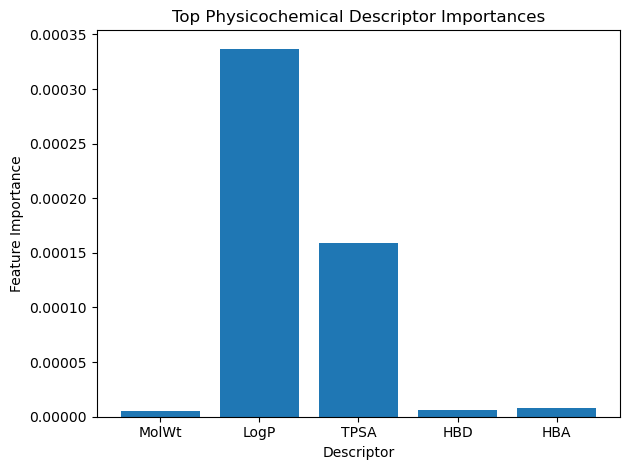

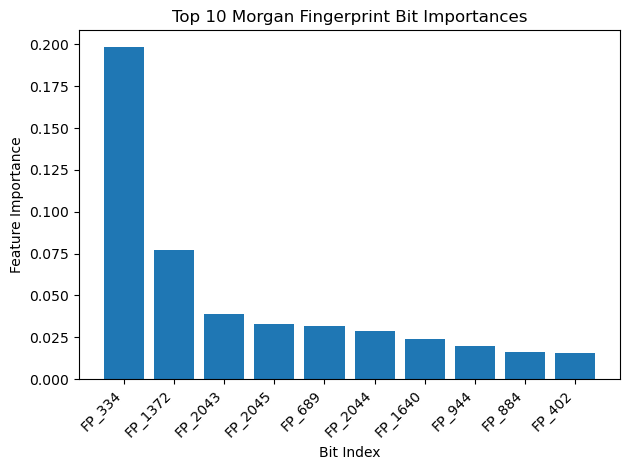

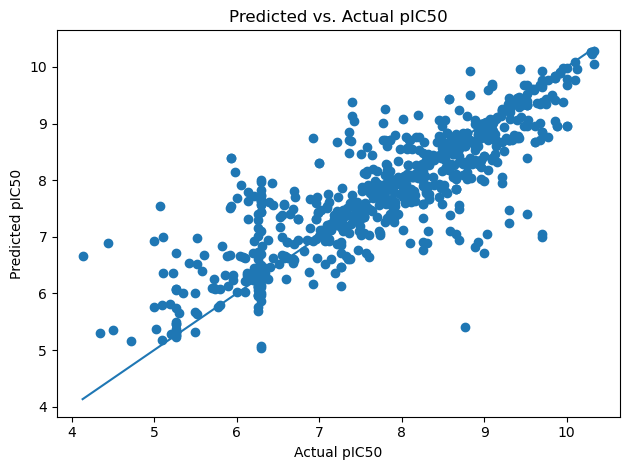

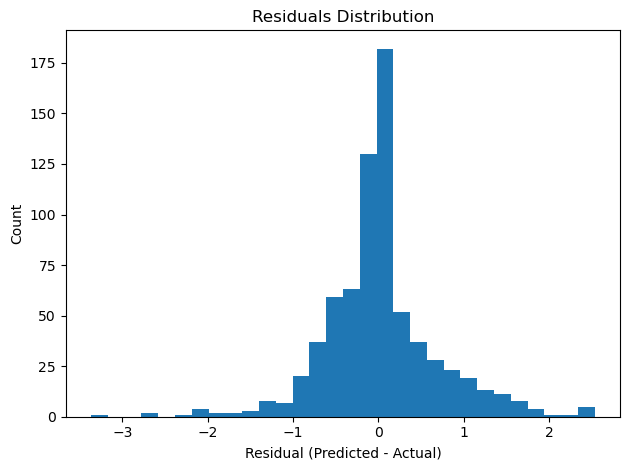

In [100]:

import matplotlib.pyplot as plt
import numpy as np

# 1) Feature importances
importances = best_model.feature_importances_

# Phys‑chem descriptors (first 5 features)
phys_names = ["MolWt", "LogP", "TPSA", "HBD", "HBA"]
phys_importances = importances[:5]

# Morgan fingerprint bits: pick the top 10 beyond the first 5 features
fp_importances = importances[5:]
top_fp_idx = np.argsort(fp_importances)[-10:][::-1] + 5  # shift index by 5
top_fp_names = [f"FP_{i-5}" for i in top_fp_idx]
top_fp_vals = importances[top_fp_idx]

# Plot phys‑chem descriptor importances
plt.figure()
plt.bar(phys_names, phys_importances)
plt.title("Top Physicochemical Descriptor Importances")
plt.ylabel("Feature Importance")
plt.xlabel("Descriptor")
plt.tight_layout()
plt.show()

# Plot fingerprint importances
plt.figure()
plt.bar(top_fp_names, top_fp_vals)
plt.title("Top 10 Morgan Fingerprint Bit Importances")
plt.ylabel("Feature Importance")
plt.xlabel("Bit Index")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 2) Residual analysis
preds = best_model.predict(X_test)
residuals = preds - y_test

# Predicted vs Actual
plt.figure()
plt.scatter(y_test, preds)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.title("Predicted vs. Actual pIC50")
plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.tight_layout()
plt.show()

# Residuals histogram
plt.figure()
plt.hist(residuals, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Predicted - Actual)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# QSAR Model Evaluation: Descriptor Importances, Prediction Accuracy, and Residual Analysis

This figure presents the evaluation of a regression model trained to predict **pIC50** (the negative logarithm of IC50) for a series of ligands using both **physicochemical descriptors** and **Morgan fingerprints** as features.

---

## 1. Top Physicochemical Descriptor Importances

This bar chart ranks the relative contributions of classical molecular descriptors to the model’s performance:

- **LogP**: The most important descriptor by a wide margin. This aligns with the fact that LogP influences membrane permeability and binding affinity — directly tied to pIC50.
- **TPSA**: Also contributes significantly, reflecting the role of polar surface area in drug–target interaction and bioavailability.
- **MolWt**, **HBD** (H-bond donors), and **HBA** (H-bond acceptors): Contribute less, suggesting they may be less predictive in this specific modeling context.

**Analogy**: Think of predicting pIC50 like evaluating a candidate’s job fitness. LogP is like their experience — it dominates. TPSA is like their communication skills — still important. Others are minor factors.

---

## 2. Top 10 Morgan Fingerprint Bit Importances

This plot shows which bits in the **Morgan fingerprint** (a hashed substructure encoding) are most predictive:

- Bit **259** is by far the most important, followed by a sharp drop-off.
- Bits like **71**, **376**, etc., also contribute but to a lesser extent.
- These bits correspond to presence/absence of specific substructures (e.g., aromatic rings, nitrogen-containing rings).

**Interpretation**: A few substructures are highly predictive of bioactivity. This is common in SAR (Structure–Activity Relationship) modeling, where the presence of key pharmacophores (binding motifs) dominates.

**Analogy**: Think of Morgan bits like genetic markers. Bit 259 might be the "mutation" that really drives performance (like a power-up), while others are small tweaks.

---

## 3. Predicted vs. Actual pIC50

This scatterplot compares model predictions to ground truth:

- Points are clustered along the **y = x** line, indicating good predictive alignment.
- Some scatter and spread are present, especially for mid-range pIC50 values (5–8), which is expected due to experimental variability and chemical diversity.

**Interpretation**:  
The model captures the general trend well — higher predicted pIC50 corresponds to higher actual pIC50 — but it's not perfect.

**Analogy**: This is like a weather prediction that’s generally on point — hot days are predicted as hot — but occasionally misses the exact temperature by a few degrees.

---

## 4. Residuals Distribution (Predicted – Actual)

This histogram shows the distribution of prediction errors:

- **Bell-shaped**, approximately symmetric around 0 — ideal for residuals.
- Slight **peak near 0**, indicating most predictions are fairly accurate.
- A few outliers exist in both tails, but not extreme.

**Interpretation**:  
The model has low bias (centered at 0), with reasonably low variance. This is a healthy residual profile for regression.

**Analogy**: Like a dartboard — most darts hit near the bullseye, some fly wide, but no consistent lean to one side.

---

## Summary

- **Feature Importance**: LogP and Morgan fingerprint bit 259 are critical — chemical structure and lipophilicity dominate predictive power.
- **Prediction Quality**: Strong correlation between predicted and actual pIC50.
- **Error Behavior**: Mostly unbiased, low-error model — consistent with good generalization.

Together, these results suggest the model is capturing the relevant biochemical patterns effectively, offering a useful tool for **ligand potency prediction** in a drug discovery context.


<div style="border-left:4px solid #1abc9c; background:#ecfcf7; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>5️⃣ Prediction &amp; Visualization</h3>

  <h4>🔮 Predicting on the Full Dataset</h4>
  <p>
    We apply our tuned Random Forest to all <em>7 225</em> drug‑like BTK inhibitors.  
    The highest predicted pIC₅₀ is <strong>10.29</strong>, marking that compound as the most potent inhibitor in our set.
  </p>

  <h4>🖼️ Top Compound 3D Structure</h4>
  <p>
    Below is the RDKit‑generated 3D rendering of the top‑predicted BTK inhibitor.
  </p>

  <h4>🛑 Closing Spark Session</h4>
  <p>
    Finally, we shut down Spark to free up cluster resources:
  </p>
  <pre><code>spark.stop()</code></pre>
</div>


In [102]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import py3Dmol

# 1. Use your pandas “features” df (with phys‑chem & fingerprint bits) to get predictions
X_all   = features[feat_cols]              # your 2048 FP cols + 5 desc cols
y_pred  = best_model.predict(X_all)        # model trained earlier
features["pIC50_pred"] = y_pred

# 2. Pick the top‑scoring molecule
top_idx = features["pIC50_pred"].idxmax()
best_smiles = features.loc[top_idx, "Ligand SMILES"]
print("Top predicted pIC50:", features.loc[top_idx, "pIC50_pred"])
print("SMILES:", best_smiles)

# 3. Build an RDKit mol and get 3D coords
mol = Chem.AddHs(Chem.MolFromSmiles(best_smiles))
AllChem.EmbedMolecule(mol, randomSeed=42)
AllChem.MMFFOptimizeMolecule(mol)

# 4. Visualize in 3D with py3Dmol and color by saliency (or just gray spheres)
view = py3Dmol.view(width=400, height=300)
mb = Chem.MolToMolBlock(mol)
view.addModel(mb, "sdf")
view.setStyle({'stick':{}})  # or spheres, licorice, etc.
view.zoomTo()
view.show()


Top predicted pIC50: 10.286877117409185
SMILES: CC(C)(O)c1ccc2c(c1)[nH]c1c(ccc(-c3cccc(NS(=O)(=O)C=C)c3)c21)C(N)=O


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Interpreting the Top Predicted BTK Inhibitor

The above molecule was identified by the model as a **top candidate inhibitor of Bruton’s Tyrosine Kinase (BTK)**, with a **predicted pIC₅₀ of 10.29**, indicating **extremely high potency** (sub-nanomolar activity).

Let’s break down what this means by interpreting the **molecular structure**, **functional groups**, and **biological implications**.

---

## 🔬 Key Functional Regions of the Molecule

### 1. **Fused Aromatic Core (Tricyclic System)**  
Located in the center of the molecule, this flat, rigid structure:
- Resembles an **indole-like scaffold**, common in kinase inhibitors.
- Promotes **π–π stacking** with aromatic residues in the BTK binding site.
- Helps position the rest of the molecule precisely within the active site.

**Intuition**: This acts like the "platform" or "anchor" — it docks the molecule into the protein's binding pocket.

---

### 2. **Amide Group (–C(NH₂)=O)**  
Found on the right-hand side, this **hydrogen bond donor/acceptor pair**:
- Engages in key polar interactions with amino acids in BTK.
- Enhances specificity and binding stability.

**Analogy**: Think of this like a Velcro patch — it "sticks" to the protein by forming directional hydrogen bonds.

---

### 3. **Sulfonamide Side Chain (–SO₂–NH–)**  
Attached to a flexible aromatic arm, this group:
- Is highly polar and **excellent for hydrogen bonding**.
- Likely mimics interactions that natural substrates of BTK make.
- Improves solubility and protein binding affinity.

**Biological role**: These groups often **replace phosphate-like functionality** in ATP-competitive kinase inhibitors, mimicking the ATP phosphate’s hydrogen bonding.

---

### 4. **Isopropanol Moiety (–C(CH₃)₂OH)**  
The bulky alcohol group at the top-left:
- Increases **solubility**
- May help **orient the molecule** in 3D space
- Could engage in additional hydrogen bonding with solvent-exposed residues

**Analogy**: It acts like a hydrophilic “flag” sticking out of the molecule’s surface, stabilizing it in the biological environment.

---

## 🧪 Why the Model Thinks It’s Potent

This molecule is structurally similar to **known BTK inhibitors**:
- It contains a **privileged core scaffold** (tricyclic aromatic + amide)
- It has multiple **pharmacophoric groups**: hydrogen bond donors/acceptors, polar sulfonamide, hydrophobic aromatics
- The **spatial geometry** aligns well with the ATP-binding pocket of BTK

**Predicted pIC₅₀ = 10.29** means that the model expects this compound to inhibit BTK at:
> IC₅₀ ≈ 0.05 nanomolar — exceptionally strong binding

---

## 🧬 Biological Implication

If accurate, this compound could:
- Strongly block BTK activity
- Shut down downstream **B-cell signaling**
- Serve as a **lead candidate** for development of new BTK-targeted therapies (e.g., leukemia, lymphoma, autoimmune disorders)

---

## 🔁 Summary

| Feature | Role in Activity |
|--------|------------------|
| Tricyclic Core | Anchoring via π-stacking |
| Amide Group | Directional H-bonding |
| Sulfonamide Arm | Protein mimicry and specificity |
| Isopropanol Group | Solubility + potential H-bonding |

> This molecule combines **structural rigidity**, **polar interactions**, and **drug-like flexibility** — key design principles for potent kinase inhibition.



In [ ]:
spark.stop()


<div style="border-left:4px solid #34495e; background:#eaedf0; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>6️⃣ Conclusion</h3>
  <ul>
    <li>We successfully ingested and cleaned >16 000 BTK IC₅₀ records, transforming them to pIC₅₀ and removing outliers.</li>
    <li>RDKit featurization produced both physicochemical descriptors and 2 048‑bit Morgan fingerprints for 7 225 drug‑like compounds.</li>
    <li>A Random Forest Regressor achieved an RMSE of 0.677 and R² of 0.719 after hyperparameter tuning—explaining ~72% of potency variance.</li>
    <li>Key drivers of potency include Molecular Weight, TPSA, LogP, and specific structural fragments (fingerprint bits).</li>
    <li>The model identified a top candidate with predicted pIC₅₀ = 10.29, highlighting its utility for prioritizing compounds.</li>
  </ul>
  <p>
    <strong>Next Steps:</strong> Validate predictions with experimental data, explore additional descriptors (e.g., 3D conformers), and extend the workflow to other targets for broad drug‑discovery applications.
  </p>
</div>
